## Import

In [1]:
from yasai_funcs import yasai
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import optim
from PIL import Image
import torch.nn.functional as F
import cv2
# from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# ### for_multi_GPU
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

# print(torch.cuda.device_count())
# print(torch.cuda.is_available())

## Root

In [3]:
ROOT_PATH = '/home/yasaisen/Desktop/09_research/09_research_main/lab_11'

In [4]:
dataset_folder = 'finetuneset_v1.0.0'

train_img_path = os.path.join(ROOT_PATH, dataset_folder, 'finetune_train_set')
valid_img_path = os.path.join(ROOT_PATH, dataset_folder, 'finetune_valid_set')
test_img_path = os.path.join(ROOT_PATH, dataset_folder, 'finetune_test_set')

## Aug

In [5]:
img_size = 224
train_bsz = 80
device = 'cuda'
epochs = 30
valid_bsz = 8
test_bsz = 8
CLASSES = ['NORMAL', 'RLN', 'RSLN']

## Dataset

In [6]:
def get_df(img_path):
    images, labels = [], []

    i = 0

    for get_img_name in os.listdir(img_path):
        images += [os.path.join(img_path, get_img_name)]
        labels += [get_img_name.split('_')[0]]
        
        i = i+1

    PathDF = pd.DataFrame({'images': images, 'labels': labels})
    print(i)
    PathDF.head()
    return PathDF

In [7]:
train_df = get_df(train_img_path)
valid_df = get_df(valid_img_path)
test_df = get_df(test_img_path)

3788
1037
917


In [8]:
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [9]:
train_df.groupby('labels').agg('size')

labels
NORMAL     818
RLN       1593
RSLN      1377
dtype: int64

In [10]:
transform = transforms.Compose([
            transforms.ToTensor()
            ])

In [11]:
class mod_Dataset(Dataset):
    def __init__(self, path_df, transform=None):
        self.path_df = path_df
        self.transform = transform

    def __len__(self):
        return self.path_df.shape[0]
    
    def __getitem__(self, idx):
        if self.transform is not None:
            trans_Resize = transforms.Resize(224)

            images = trans_Resize(Image.open(self.path_df.iloc[idx]['images']).convert('RGB'))
            images = self.transform(images)

            if self.path_df.iloc[idx]['labels'] == CLASSES[0]:
                lables = torch.tensor([1, 0, 0], dtype=torch.float32)
            if self.path_df.iloc[idx]['labels'] == CLASSES[1]:
                lables = torch.tensor([0, 1, 0], dtype=torch.float32)
            if self.path_df.iloc[idx]['labels'] == CLASSES[2]:
                lables = torch.tensor([0, 0, 1], dtype=torch.float32)

        return images, lables

In [12]:
train_data = mod_Dataset(train_df, transform)
valid_data = mod_Dataset(valid_df, transform)
test_data  = mod_Dataset(test_df, transform)

train_loader = DataLoader(train_data, batch_size=train_bsz, shuffle=True , num_workers=0, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=valid_bsz, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_data , batch_size=test_bsz , shuffle=False, num_workers=0)

## Model

In [13]:
class resnet34(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.base_model = torchvision.models.resnet34()
        self.fc1 = nn.Linear(1000, num_classes)

    def forward(self, input):
        output = self.base_model(input)
        output = self.fc1(output)
        output = torch.softmax(output, dim=1)
        return output

In [14]:
model = resnet34(len(CLASSES)).to(device)
# print(model)
t = torch.randn((4, 3, 224, 224)).to(device)
print(t.shape)
get = model(t)
print(get.shape)

for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([4, 3, 224, 224])
torch.Size([4, 3])
torch.Size([80, 3, 224, 224])
torch.Size([80, 3])


## Train

In [15]:
def check_accuracy(loader, model, device):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)
            _, y = y.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return (num_correct/num_samples).item()

def train(epochs, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


    for epoch in range(epochs):
        model.train()
        losses = []

        pbar = tqdm(train_loader, total=len(train_loader), position=0, leave=True, desc=f"Epoch {epoch}")
        for data, targets in pbar:
            data = data.to(device)
            targets = targets.to(device)

            # forward
            scores = model(data)
            # print(scores)
            loss = criterion(scores, targets)
            losses.append(loss.item())
            # backward
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
        
        avg_loss = sum(losses) / len(losses)
        acc = check_accuracy(test_loader, model, device)
        print(f"Loss:{avg_loss:.8f}\tAccuracy:{acc:.8f}")

    return model

In [16]:
trained_resnet34_model = train(100, model)

Epoch 0: 100%|██████████| 47/47 [00:14<00:00,  3.16it/s]


Loss:1.04195985	Accuracy:0.21374045


Epoch 1: 100%|██████████| 47/47 [00:14<00:00,  3.16it/s]


Loss:0.96832250	Accuracy:0.43511447


Epoch 2: 100%|██████████| 47/47 [00:14<00:00,  3.18it/s]


Loss:0.80005421	Accuracy:0.31406760


Epoch 3: 100%|██████████| 47/47 [00:14<00:00,  3.18it/s]


Loss:0.68246922	Accuracy:0.57360959


Epoch 4: 100%|██████████| 47/47 [00:15<00:00,  3.10it/s]


Loss:0.62823984	Accuracy:0.52126497


Epoch 5: 100%|██████████| 47/47 [00:15<00:00,  3.11it/s]


Loss:0.60173058	Accuracy:0.50817883


Epoch 6: 100%|██████████| 47/47 [00:14<00:00,  3.15it/s]


Loss:0.58508340	Accuracy:0.42966193


Epoch 7: 100%|██████████| 47/47 [00:15<00:00,  3.12it/s]


Loss:0.57906918	Accuracy:0.48091602


Epoch 8: 100%|██████████| 47/47 [00:15<00:00,  3.10it/s]


Loss:0.56888149	Accuracy:0.53980368


Epoch 9: 100%|██████████| 47/47 [00:15<00:00,  3.04it/s]


Loss:0.56092442	Accuracy:0.48636857


Epoch 10: 100%|██████████| 47/47 [00:15<00:00,  3.07it/s]


Loss:0.55800886	Accuracy:0.46455833


Epoch 11: 100%|██████████| 47/47 [00:15<00:00,  3.05it/s]


Loss:0.55747238	Accuracy:0.43184295


Epoch 12: 100%|██████████| 47/47 [00:15<00:00,  3.08it/s]


Loss:0.55530016	Accuracy:0.45256269


Epoch 13: 100%|██████████| 47/47 [00:15<00:00,  3.03it/s]


Loss:0.55825919	Accuracy:0.48091602


Epoch 14: 100%|██████████| 47/47 [00:15<00:00,  3.09it/s]


Loss:0.55565778	Accuracy:0.44601962


Epoch 15: 100%|██████████| 47/47 [00:15<00:00,  3.04it/s]


Loss:0.55705023	Accuracy:0.53217012


Epoch 16: 100%|██████████| 47/47 [00:15<00:00,  3.12it/s]


Loss:0.55455636	Accuracy:0.41221371


Epoch 17: 100%|██████████| 47/47 [00:14<00:00,  3.15it/s]


Loss:0.55456171	Accuracy:0.41984731


Epoch 18: 100%|██████████| 47/47 [00:15<00:00,  3.13it/s]


Loss:0.55331095	Accuracy:0.40130860


Epoch 19: 100%|██████████| 47/47 [00:15<00:00,  3.05it/s]


Loss:0.55372753	Accuracy:0.43947655


Epoch 20: 100%|██████████| 47/47 [00:15<00:00,  3.06it/s]


Loss:0.55306454	Accuracy:0.46019629


Epoch 21: 100%|██████████| 47/47 [00:15<00:00,  3.08it/s]


Loss:0.55248013	Accuracy:0.46019629


Epoch 22: 100%|██████████| 47/47 [00:15<00:00,  3.01it/s]


Loss:0.55245849	Accuracy:0.40458015


Epoch 23: 100%|██████████| 47/47 [00:15<00:00,  3.01it/s]


Loss:0.55250037	Accuracy:0.39040348


Epoch 24: 100%|██████████| 47/47 [00:15<00:00,  3.04it/s]


Loss:0.55231748	Accuracy:0.43838602


Epoch 25: 100%|██████████| 47/47 [00:15<00:00,  3.06it/s]


Loss:0.55214472	Accuracy:0.41548526


Epoch 26: 100%|██████████| 47/47 [00:15<00:00,  3.09it/s]


Loss:0.55236579	Accuracy:0.36532170


Epoch 27: 100%|██████████| 47/47 [00:15<00:00,  3.08it/s]


Loss:0.55312996	Accuracy:0.47110140


Epoch 28: 100%|██████████| 47/47 [00:15<00:00,  3.07it/s]


Loss:0.55349009	Accuracy:0.41112322


Epoch 29: 100%|██████████| 47/47 [00:15<00:00,  3.05it/s]


Loss:0.55609013	Accuracy:0.39912757


Epoch 30: 100%|██████████| 47/47 [00:15<00:00,  3.04it/s]


Loss:0.55345253	Accuracy:0.43184295


Epoch 31: 100%|██████████| 47/47 [00:15<00:00,  2.98it/s]


Loss:0.55230591	Accuracy:0.47655395


Epoch 32: 100%|██████████| 47/47 [00:15<00:00,  3.09it/s]


Loss:0.55267501	Accuracy:0.48745909


Epoch 33: 100%|██████████| 47/47 [00:15<00:00,  3.09it/s]


Loss:0.55422017	Accuracy:0.44601962


Epoch 34: 100%|██████████| 47/47 [00:15<00:00,  3.09it/s]


Loss:0.55651656	Accuracy:0.61068702


Epoch 35: 100%|██████████| 47/47 [00:15<00:00,  3.01it/s]


Loss:0.56212566	Accuracy:0.37622681


Epoch 36: 100%|██████████| 47/47 [00:15<00:00,  3.05it/s]


Loss:0.55640460	Accuracy:0.45692474


Epoch 37: 100%|██████████| 47/47 [00:15<00:00,  3.05it/s]


Loss:0.55486257	Accuracy:0.49836421


Epoch 38: 100%|██████████| 47/47 [00:15<00:00,  3.02it/s]


Loss:0.55322648	Accuracy:0.37731731


Epoch 39: 100%|██████████| 47/47 [00:15<00:00,  3.00it/s]


Loss:0.55206475	Accuracy:0.45910576


Epoch 40: 100%|██████████| 47/47 [00:15<00:00,  3.04it/s]


Loss:0.55190049	Accuracy:0.46128678


Epoch 41: 100%|██████████| 47/47 [00:15<00:00,  3.05it/s]


Loss:0.55203234	Accuracy:0.44383860


Epoch 42: 100%|██████████| 47/47 [00:15<00:00,  3.00it/s]


Loss:0.55192880	Accuracy:0.41330424


Epoch 43: 100%|██████████| 47/47 [00:15<00:00,  3.05it/s]


Loss:0.55195020	Accuracy:0.41112322


Epoch 44: 100%|██████████| 47/47 [00:15<00:00,  3.10it/s]


Loss:0.55177279	Accuracy:0.45365319


Epoch 45: 100%|██████████| 47/47 [00:15<00:00,  3.11it/s]


Loss:0.55183684	Accuracy:0.45692474


Epoch 46: 100%|██████████| 47/47 [00:15<00:00,  3.08it/s]


Loss:0.55188678	Accuracy:0.43511447


Epoch 47: 100%|██████████| 47/47 [00:15<00:00,  3.01it/s]


Loss:0.55181376	Accuracy:0.43293345


Epoch 48: 100%|██████████| 47/47 [00:15<00:00,  3.07it/s]


Loss:0.55179778	Accuracy:0.40458015


Epoch 49: 100%|██████████| 47/47 [00:14<00:00,  3.19it/s]


Loss:0.55182101	Accuracy:0.46892038


Epoch 50: 100%|██████████| 47/47 [00:14<00:00,  3.22it/s]


Loss:0.55176471	Accuracy:0.42857140


Epoch 51: 100%|██████████| 47/47 [00:14<00:00,  3.15it/s]


Loss:0.55192202	Accuracy:0.40021810


Epoch 52: 100%|██████████| 47/47 [00:14<00:00,  3.25it/s]


Loss:0.55242685	Accuracy:0.51690292


Epoch 53: 100%|██████████| 47/47 [00:15<00:00,  3.08it/s]


Loss:0.55197706	Accuracy:0.49509266


Epoch 54: 100%|██████████| 47/47 [00:14<00:00,  3.22it/s]


Loss:0.55191693	Accuracy:0.47110140


Epoch 55: 100%|██████████| 47/47 [00:14<00:00,  3.16it/s]


Loss:0.55179785	Accuracy:0.44820064


Epoch 56: 100%|██████████| 47/47 [00:14<00:00,  3.14it/s]


Loss:0.55182801	Accuracy:0.44601962


Epoch 57: 100%|██████████| 47/47 [00:15<00:00,  3.11it/s]


Loss:0.55185262	Accuracy:0.42311886


Epoch 58: 100%|██████████| 47/47 [00:14<00:00,  3.20it/s]


Loss:0.55176578	Accuracy:0.46346781


Epoch 59: 100%|██████████| 47/47 [00:14<00:00,  3.26it/s]


Loss:0.55180655	Accuracy:0.40239912


Epoch 60: 100%|██████████| 47/47 [00:14<00:00,  3.15it/s]


Loss:0.55181737	Accuracy:0.46346781


Epoch 61: 100%|██████████| 47/47 [00:14<00:00,  3.18it/s]


Loss:0.55181714	Accuracy:0.43511447


Epoch 62: 100%|██████████| 47/47 [00:14<00:00,  3.25it/s]


Loss:0.55185565	Accuracy:0.42966193


Epoch 63: 100%|██████████| 47/47 [00:14<00:00,  3.14it/s]


Loss:0.55294275	Accuracy:0.41221371


Epoch 64: 100%|██████████| 47/47 [00:14<00:00,  3.24it/s]


Loss:0.56286881	Accuracy:0.40021810


Epoch 65: 100%|██████████| 47/47 [00:14<00:00,  3.25it/s]


Loss:0.56135852	Accuracy:0.44492909


Epoch 66: 100%|██████████| 47/47 [00:14<00:00,  3.18it/s]


Loss:0.55551819	Accuracy:0.45692474


Epoch 67: 100%|██████████| 47/47 [00:15<00:00,  3.06it/s]


Loss:0.55271257	Accuracy:0.42202833


Epoch 68: 100%|██████████| 47/47 [00:14<00:00,  3.20it/s]


Loss:0.55214476	Accuracy:0.37622681


Epoch 69: 100%|██████████| 47/47 [00:14<00:00,  3.15it/s]


Loss:0.55192250	Accuracy:0.40894219


Epoch 70: 100%|██████████| 47/47 [00:14<00:00,  3.18it/s]


Loss:0.55235533	Accuracy:0.44711012


Epoch 71: 100%|██████████| 47/47 [00:14<00:00,  3.16it/s]


Loss:0.55278837	Accuracy:0.41875678


Epoch 72: 100%|██████████| 47/47 [00:15<00:00,  3.12it/s]


Loss:0.55242796	Accuracy:0.39367500


Epoch 73: 100%|██████████| 47/47 [00:15<00:00,  3.05it/s]


Loss:0.55181409	Accuracy:0.39912757


Epoch 74: 100%|██████████| 47/47 [00:14<00:00,  3.22it/s]


Loss:0.55188329	Accuracy:0.42202833


Epoch 75: 100%|██████████| 47/47 [00:14<00:00,  3.20it/s]


Loss:0.55178758	Accuracy:0.40894219


Epoch 76: 100%|██████████| 47/47 [00:14<00:00,  3.21it/s]


Loss:0.55188459	Accuracy:0.32606325


Epoch 77: 100%|██████████| 47/47 [00:14<00:00,  3.21it/s]


Loss:0.55307415	Accuracy:0.46673936


Epoch 78: 100%|██████████| 47/47 [00:15<00:00,  3.10it/s]


Loss:0.55693133	Accuracy:0.41330424


Epoch 79: 100%|██████████| 47/47 [00:14<00:00,  3.21it/s]


Loss:0.55480370	Accuracy:0.46346781


Epoch 80: 100%|██████████| 47/47 [00:14<00:00,  3.23it/s]


Loss:0.55445300	Accuracy:0.49727368


Epoch 81: 100%|██████████| 47/47 [00:14<00:00,  3.21it/s]


Loss:0.55213919	Accuracy:0.51035982


Epoch 82: 100%|██████████| 47/47 [00:14<00:00,  3.23it/s]


Loss:0.55190595	Accuracy:0.42857140


Epoch 83: 100%|██████████| 47/47 [00:15<00:00,  3.11it/s]


Loss:0.55188179	Accuracy:0.40348962


Epoch 84: 100%|██████████| 47/47 [00:15<00:00,  3.05it/s]


Loss:0.55180432	Accuracy:0.38167939


Epoch 85: 100%|██████████| 47/47 [00:14<00:00,  3.14it/s]


Loss:0.55179264	Accuracy:0.38931295


Epoch 86: 100%|██████████| 47/47 [00:14<00:00,  3.18it/s]


Loss:0.55177901	Accuracy:0.40676117


Epoch 87: 100%|██████████| 47/47 [00:14<00:00,  3.26it/s]


Loss:0.55174426	Accuracy:0.38604143


Epoch 88: 100%|██████████| 47/47 [00:14<00:00,  3.16it/s]


Loss:0.55175611	Accuracy:0.40239912


Epoch 89: 100%|██████████| 47/47 [00:15<00:00,  3.10it/s]


Loss:0.55204596	Accuracy:0.41330424


Epoch 90: 100%|██████████| 47/47 [00:14<00:00,  3.14it/s]


Loss:0.55187083	Accuracy:0.45147216


Epoch 91: 100%|██████████| 47/47 [00:14<00:00,  3.18it/s]


Loss:0.55172985	Accuracy:0.40676117


Epoch 92: 100%|██████████| 47/47 [00:14<00:00,  3.23it/s]


Loss:0.55174728	Accuracy:0.38058886


Epoch 93: 100%|██████████| 47/47 [00:14<00:00,  3.23it/s]


Loss:0.55187686	Accuracy:0.44820064


Epoch 94: 100%|██████████| 47/47 [00:15<00:00,  3.06it/s]


Loss:0.55175288	Accuracy:0.43402398


Epoch 95: 100%|██████████| 47/47 [00:14<00:00,  3.18it/s]


Loss:0.55173030	Accuracy:0.42311886


Epoch 96: 100%|██████████| 47/47 [00:14<00:00,  3.17it/s]


Loss:0.55173639	Accuracy:0.41875678


Epoch 97: 100%|██████████| 47/47 [00:14<00:00,  3.22it/s]


Loss:0.55176822	Accuracy:0.41875678


Epoch 98: 100%|██████████| 47/47 [00:14<00:00,  3.18it/s]


Loss:0.55172286	Accuracy:0.42748091


Epoch 99: 100%|██████████| 47/47 [00:14<00:00,  3.27it/s]


Loss:0.55536570	Accuracy:0.47110140


In [17]:
yasai.model_save_v1(trained_resnet34_model, 'resnet34_trainsteprgb_2305290849_')

Successfully saved to /home/yasaisen/Desktop/09_research/09_research_main/lab_11/model_resnet34_trainsteprgb_2305290849_2305292019.pt


In [18]:
# trained_resnet34_model = yasai.model_load_v1('/home/yasaisen/Desktop/09_research/09_research_main/lab_11/model_resnet34_trainsteprgb_2305290849_2305291051.pt')

accuracy = 0.3741562198649952
avg_precision = 0.12471873995487813
avg_recall = 0.3333333333324742


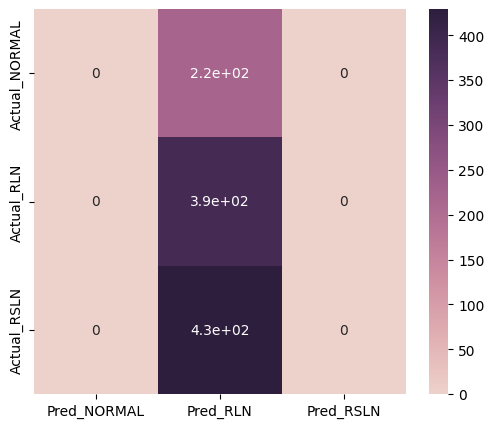

In [19]:
_ = yasai.confusion_matrix(valid_data, trained_resnet34_model, CLASSES)

accuracy = 0.44383860414394766
avg_precision = 0.14794620138115455
avg_recall = 0.33333333333251436


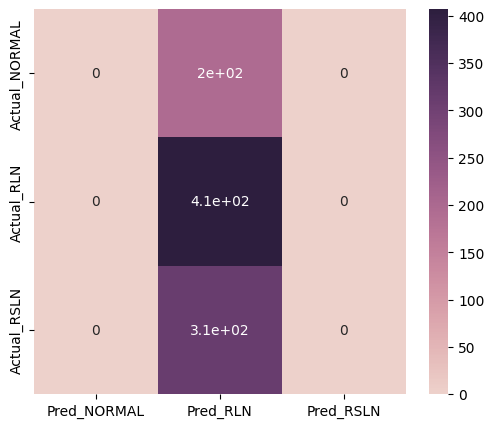

In [20]:
_ = yasai.confusion_matrix(test_data, trained_resnet34_model, CLASSES)

accuracy = 0.42053854276663144
avg_precision = 0.14021653023497752
avg_recall = 0.3333333333331241


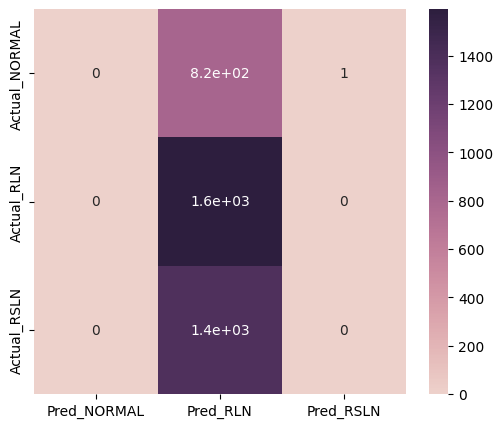

In [21]:
_ = yasai.confusion_matrix(train_data, trained_resnet34_model, CLASSES)

In [22]:
t = torch.randn((1, 3, 224, 224)).to(device)
print(t.shape)
get = trained_resnet34_model(t)
print(get)

torch.Size([1, 3, 224, 224])
tensor([[0.0107, 0.5960, 0.3933]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
